/Users/richard/miniforge3/envs/xxy/lib/python3.14/site-packages/kwant/lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
/Users/richard/miniforge3/envs/xxy/lib/python3.14/site-packages/kwant/_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


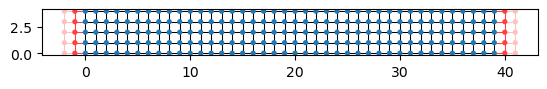

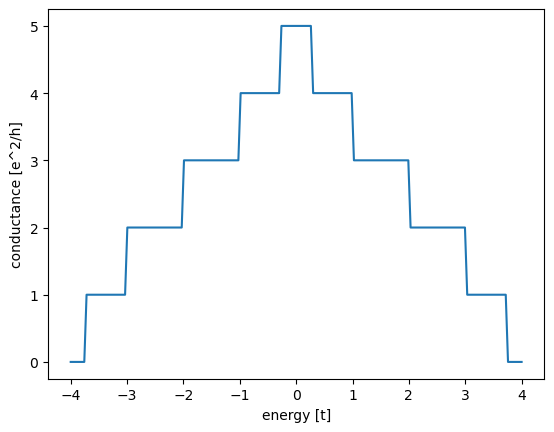

In [1]:
import kwant
import numpy as np
from matplotlib import pyplot


def make_system():
    a = 1  # 晶格常数
    lat = kwant.lattice.square(a)  # 创建晶格，方格子

    syst = kwant.Builder()  # 建立中心体系
    t = 1.0  # hopping值
    W = 5  # 中心体系宽度
    L = 40  # 中心体系长度

    # 给中心体系赋值
    for i in range(L):
        for j in range(W):
            syst[lat(i, j)] = 0
            if j > 0:
                syst[lat(i, j), lat(i, j-1)] = -t  # hopping in y-direction
            if i > 0:
                syst[lat(i, j), lat(i-1, j)] = -t  # hopping in x-direction

    sym_left_lead = kwant.TranslationalSymmetry((-a, 0))  # 电极的平移对称性，(-a, 0)代表远离中心区的方向，向左
    left_lead = kwant.Builder(sym_left_lead)  # 建立左电极体系
    # 给电极体系赋值
    for j in range(W):
        left_lead[lat(0, j)] = 0
        if j > 0:
            left_lead[lat(0, j), lat(0, j - 1)] = -t
        left_lead[lat(1, j), lat(0, j)] = -t  # 这里写一个即可，因为平移对称性已经声明了
    syst.attach_lead(left_lead)  # 把左电极接在中心区

    sym_right_lead = kwant.TranslationalSymmetry((a, 0))
    right_lead = kwant.Builder(sym_right_lead)
    for j in range(W):
        right_lead[lat(0, j)] = 0
        if j > 0:
            right_lead[lat(0, j), lat(0, j - 1)] = -t
        right_lead[lat(1, j), lat(0, j)] = -t
    syst.attach_lead(right_lead)  # 把右电极接在中心区

    kwant.plot(syst)  # 把电极-中心区-电极图画出来，通过图像可以看出有没有写错
    syst = syst.finalized()  # 结束体系的制作。这个语句不可以省。这个语句是把Builder对象转换成可计算的对象。
    return syst


def make_system_with_less_code():
    a = 1  # 晶格常数
    lat = kwant.lattice.square(a)  # 创建晶格，方格子

    syst = kwant.Builder()  # 建立中心体系
    t = 1.0  # hopping值
    W = 5  # 中心体系宽度
    L = 40  # 中心体系长度

    # 中心区
    syst[(lat(x, y) for x in range(L) for y in range(W))] = 0
    syst[lat.neighbors()] = -t  # 用neighbors()方法

    # 电极
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, j) for j in range(W))] = 0
    lead[lat.neighbors()] = -t  # 用neighbors()方法
    syst.attach_lead(lead)  # 左电极
    syst.attach_lead(lead.reversed())   # 用reversed()方法得到右电极

    kwant.plot(syst)  # 把电极-中心区-电极图画出来，通过图像可以看出有没有写错
    syst = syst.finalized()  # 结束体系的制作。这个语句不可以省。这个语句是把Builder对象转换成可计算的对象。
    return syst


def main():
    syst = make_system()
    # syst = make_system_with_less_code()  # 和上面的一样，只是用更少的代码写
    energies = np.linspace(-4, 4, 200)
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)   # compute the transmission probability from lead 0 to lead 1
        data.append(smatrix.transmission(1, 0))
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()
    # pyplot.savefig('conductance' + '.eps')


if __name__ == '__main__':
    main()